In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import truncnorm
import geopandas as gpd
from shapely.geometry import MultiPoint, Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

In [2]:
dwellingTypes = pd.read_csv('./Data/DwellingTypesByZone2006.csv')

In [3]:
profileData = pd.read_csv('./Data/ProfileDataByZone.csv')

/var/folders/7p/74395j5j7jg7r8chb_tyb6s80000gn/T/ipykernel_78185/337122855.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,

<h1>GEO FILES</h1>

In [64]:
zoneShape = gpd.read_file('./Data/GreaterMontrealZones2006_2138.shp')

In [5]:
zoneSystem = pd.DataFrame(data=zoneShape['DAUID'].values, columns=['DAUID'], dtype=str)


In [6]:

zoneSystem = zoneSystem[zoneSystem['DAUID'].str.len()==8]

<Axes: >

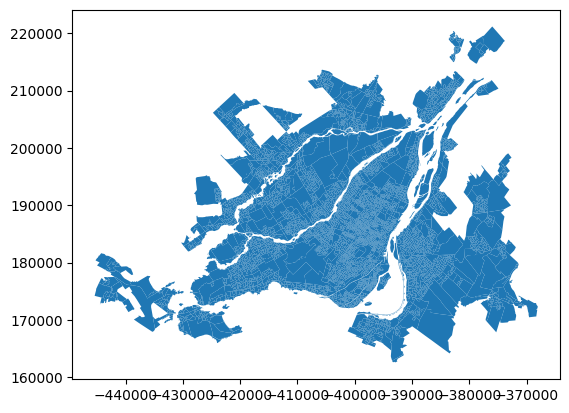

In [7]:
zoneShape.plot()

In [8]:
zoneSystem = zoneSystem[zoneSystem['DAUID'].astype(str).isin(zoneShape['DAUID'].astype(str))]

In [ ]:
zoneSystem.shape[0]

CREATE COMBINEDZONEDATA FILE

In [ ]:
zoneData = pd.DataFrame(columns=['DAUID', 'Population', 'Employment rate', 'Area', "Total - Structural type of dwelling"])
for i, zone in zoneSystem.iterrows():
    numDwellings=200
    population = 400
    try:numDwellings = dwellingTypes.loc[dwellingTypes['Geography'].astype(str)==zone['DAUID'], 'Total - Structural type of dwelling'].iloc[0]
    except:pass
    try:population = int(profileData.loc[profileData['Geography'].astype(str)==zone['DAUID'], "Population"].iloc[0])
    except:pass

    zoneData.loc[len(zoneData)] = [zone['DAUID'], population, profileData.loc[profileData['Geography'].astype(str)==zone['DAUID'], 'Employment rate'].iloc[0], float(zoneShape.loc[zoneShape['DAUID'].astype(str)==zone['DAUID'], 'geometry'].iloc[0].area), numDwellings]

zoneData.to_csv('./Data/combinedZoneData.csv', index=False)

In [3]:
zoneData = pd.read_csv('./Data/combinedZoneData.csv')

In [14]:
totalPersons = zoneData['Population'].astype(int).sum()
totalPersons

np.int64(3287231)

<h1>PERSONS</h1>

In [ ]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [ ]:
salary_distribution_employed = get_truncated_normal(mean=70000, sd=40000, low=30000, upp=200000)
salary_distribution_retired = get_truncated_normal(mean=40000, sd=20000, low=15000, upp=70000)
employment_incomes = salary_distribution_employed.rvs(int(totalPersons*.75))
retired_incomes = salary_distribution_retired.rvs(int(totalPersons*.25))

In [ ]:
for i,prof_row in profileData.iterrows():
    if prof_row['Total population 15 years and over by legal marital status - 100% data'] != '-':
        print('marriage rate', (int(prof_row['Legally married (and not separated)'])) / int(prof_row['Total population 15 years and over by legal marital status - 100% data']))

In [ ]:
def createPerson(person:"np.ndarray"):
    person[1] = -1
    person[2] = random.randint(0,100)
    person[3] = random.randint(0,1)
    person[4] = 2 if person[2] < 18 else np.random.randint(0, 2)
    person[5] = 0 if person[2] < 4 \
                    else 4 if person[2] > 65 \
                    else 2 if person[2] < 22 \
                    else 1 if np.random.random() < .70 \
                    else 2
    person[6] = 1
    person[7] = -1
    person[8] = -1
    if person[5]==1:
        person[8] = random.choice(employment_incomes)
    elif person[5]==4:
        person[8] = random.choice(retired_incomes)
    person[9] = -1
    # NATIONALITY

    if person[0]%10000==0:
        print(person[0])
    return person

In [ ]:
persons = np.empty([totalPersons,10]) # without nationality, add after

In [ ]:
persons[:,0] = np.arange(0, totalPersons, 1)

In [ ]:
np.apply_along_axis(createPerson, 1, persons)

In [ ]:
outputPersons = pd.DataFrame(columns=['id','hhId','age','gender','relationship','occupation','occupation_type','workplace','income','schoolplace'], data=persons.astype(int))

In [ ]:
outputPersons.to_csv('TESTPERSONS.csv', index=False)

<h1>DWELLINGS</h1>

In [3]:
streetNetwork_nodes = gpd.read_file('./Data/streetNetwork_nodes.gpkg')
roadPoints = streetNetwork_nodes['geometry']
roadNodes = MultiPoint(roadPoints)

In [5]:
dwelling_counts = pd.read_csv('./Data/DwellingTypesByZone2006.csv')

In [6]:
zoneShape = gpd.read_file('./Data/GreaterMontrealZones2006_2138.shp')

In [7]:
dwelling_counts = dwelling_counts[dwelling_counts['Geography'].astype(str).isin(zoneShape['DAUID'].astype(str))]
dwelling_counts = dwelling_counts.reset_index(drop=True)

In [8]:
totalDwellings = dwelling_counts['Total - Structural type of dwelling'].astype(float).sum()
totalDwellings

np.float64(1389045.0)

CEATE DWELLING COORDINATES

In [9]:
zoneShapeClone = zoneShape[zoneShape['DAUID'].astype(str).isin(zoneData['DAUID'].astype(str))]

polygons = []
for i in range(zoneShapeClone.shape[0]):
    polygons.append(zoneShapeClone.iloc[i]['geometry'])
    
geoseries = gpd.GeoSeries(polygons, zoneData['DAUID'])
dwelling_coords = geoseries.sample_points(size=zoneData['Total - Structural type of dwelling'].astype(float).astype(int))
dwelling_coords = dwelling_coords.explode(index_parts=True)

CREATE DWELLINGS

In [14]:
dwellings = np.empty([int(totalDwellings), 14])

In [15]:
dwellings[:,0] = np.arange(0, totalDwellings, 1)

In [ ]:
lastDwelling = 0
iters = 0
for ind, zone_dwellings in dwelling_counts.iterrows():
    print(iters)
    iters+=1
    count = int(float(zone_dwellings['Total - Structural type of dwelling']))
    zone = int(zone_dwellings['Geography'])

    dwellings[lastDwelling:lastDwelling+count,1] = zone

    # apply structural types of dwellings
    lastDwellingTypeIndex = lastDwelling
    SFD = int(float(zone_dwellings['Single-detached house']))
    SFA = int(float(zone_dwellings['Semi-detached house']))
    MF234 = int(float(zone_dwellings['Apartment, duplex']) + \
        float(zone_dwellings['Row house']))
    MF5plus = int(float(zone_dwellings['Apartment, building that has five or more storeys']) + \
        float(zone_dwellings['Apartment, building that has fewer than five storeys']))
    MH = int(float(zone_dwellings['Movable dwelling']))

    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+SFD,2] = 0
    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+SFD,9] = [2200 + random.randint(-400,400) for i in range(SFD)]
    lastDwellingTypeIndex = lastDwellingTypeIndex+SFD

    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+SFA,2] = 1
    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+SFA,9] = [1100 + random.randint(-200, 100) for i in  range(SFA)]
    lastDwellingTypeIndex = lastDwellingTypeIndex+SFA

    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+MF234,2] = 2
    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+MF234,9] = [400 + random.randint(-300, 100) for i in range(MF234)]
    lastDwellingTypeIndex = lastDwellingTypeIndex+MF234

    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+MF5plus,2] = 3
    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+MF5plus,9] = [400 + random.randint(-300, 100) for i in range(MF5plus)]
    lastDwellingTypeIndex = lastDwellingTypeIndex+MF5plus

    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+MH,2] = 4
    dwellings[lastDwellingTypeIndex:lastDwellingTypeIndex+MH,9] = 400 # This is off cause I don't know what MH is
    lastDwellingTypeIndex = lastDwellingTypeIndex+MH

    dwellings[lastDwellingTypeIndex:lastDwelling+count,2] = 0
    # # DONE DWELLING TYPES

    # # hhId set to 0 until linking
    dwellings[lastDwelling:lastDwelling+count,3] = -1

    # # number of bedrooms
    dwellings[lastDwelling:lastDwelling+count,4] = random.randint(1,4)

    # # quality of dwelling
    quality = [random.randint(1,4) for i in range(count)]
    dwellings[lastDwelling:lastDwelling+count,5] = quality

    # # monthly cost
    costs = np.apply_along_axis(lambda x:2500 - (x-1)*350, 1, np.array([quality]))
    dwellings[lastDwelling:lastDwelling+count,6] = costs

    # # restriction
    dwellings[lastDwelling:lastDwelling+count,7] = 0

    # # year built
    construction_years = np.apply_along_axis(lambda x:random.randint(1980, 2006) - (x-1)*20, 1, np.array([quality]))
    dwellings[lastDwelling:lastDwelling+count,8] = construction_years

    # dwellings[lastDwelling:lastDwelling+count,2:9] = [0,-1,random.randint(1,4),quality,2500 - (quality-1)*350,0,random.randint(1980, 2006) - (quality-1)*20]
    # building (size)
    dwellings[lastDwelling:lastDwelling+count,10] = 2 # medium building

    # # usage (unused)
    dwellings[lastDwelling:lastDwelling+count,11] = 0

    

    # # choose coordinate position for dwelling inside correct zone
    for d in range(count):
        point = Point(float(random.choice(dwelling_coords[zone]).x), float(random.choice(dwelling_coords[zone]).y))
        # p1, p2 = nearest_points(point, roadNodes)
        dwellings[lastDwelling+d,12] = point.x
        dwellings[lastDwelling+d,13] = point.y


    lastDwelling+=count


SNAP THREADING

In [5]:
import threading

In [57]:
def snap_position(dwelling):
    point = Point(dwelling[12], dwelling[13])
    p1,p2 = nearest_points(point, roadNodes)
    dwelling[12] = p2.x
    dwelling[13] = p2.y

    if dwelling[0]%10000==0:
        print(dwelling[0])

In [ ]:
threads = []
count = 0
for i in range(int(dwellings.shape[0]/100000)+1):
    threads.append(threading.Thread(target=np.apply_along_axis, args=[snap_position, 1, dwellings[count:count+100000]]))
    print(i, ':', count, count+100000)
    count+=100000
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()



In [ ]:

dwelling_cols = ['id','zone','type','hhId','bedrooms','quality','monthlyCost','restriction','yearBuilt','floor','building','usage','coordX','coordY']
pd.DataFrame(data=dwellings, columns=dwelling_cols).to_csv('./Output/dd_2006_linked.csv', index=False)

<h1>JOBS</h1>

CLEAN DATA

In [ ]:
tmpJobData = pd.read_csv('./Data/jobData.csv', encoding_errors='replace')
for i in range(tmpJobData.shape[0]):
    geog = str(tmpJobData.loc[i, 'Geography']).split(' ')[0]
    try:
        float(geog)
        tmpJobData.loc[i, 'Geography'] = geog
    except:
        pass
        print('drop', geog)
        

tmpJobData.to_csv('./jobData_clean.csv', index=False)

READ CLEAN FILE BY CT ZONE AND FILTER

In [67]:
CT_job_data = pd.read_csv('./Data/jobData_clean.csv', encoding_errors='replace', dtype=str)
CT_job_data = CT_job_data[(CT_job_data['Total - Industry - Sectors - North American Industry Classification System (NAICS) 2017']!='..') & (CT_job_data['Total - Industry - Sectors - North American Industry Classification System (NAICS) 2017']!='x')]

only jobs in interested zones

In [68]:
CT_job_data = CT_job_data[CT_job_data['Geography'].astype(str).isin(zoneShape['CTUID'].astype(str))]

In [69]:
CT_job_data['Total - Industry - Sectors - North American Industry Classification System (NAICS) 2017'].astype(int).sum()

np.int64(1701295)

In [70]:
jobs_per_da = pd.DataFrame(columns=['DAUID', 'CTUID', 'numJobs'])
for i, ct_area in CT_job_data.iterrows():
    ct_area_jobs = int(ct_area['Total - Industry - Sectors - North American Industry Classification System (NAICS) 2017'])
    da_areas = zoneShape.loc[zoneShape['CTUID']==ct_area['Geography'], 'DAUID']
    for da_in_ct in da_areas:
        da_jobs = int(ct_area_jobs/da_areas.shape[0])
        jobs_per_da.loc[len(jobs_per_da)] = [da_in_ct, ct_area['Geography'], da_jobs]

In [71]:
jobs_per_da['numJobs'].astype(int).sum()

np.int64(1699445)

Job coords geoseries

In [72]:
polygons = []
zoneShapeClone = zoneShape[zoneShape['DAUID'].astype(str).isin(jobs_per_da['DAUID'].astype(str))]
for i in range(zoneShapeClone.shape[0]):
    polygons.append(zoneShapeClone.iloc[i]['geometry'])
print(len(polygons))

geoseries = gpd.GeoSeries(polygons, zoneShapeClone['DAUID'])
job_coords = geoseries.sample_points(size=jobs_per_da['numJobs'].astype(int))
job_coords = job_coords.explode(index_parts=True)

4999


In [73]:
job_headers = ["11 Agriculture, forestry, fishing and hunting","21 Mining, quarrying, and oil and gas extraction",'22 Utilities','23 Construction','31-33 Manufacturing','41 Wholesale trade','44-45 Retail trade','48-49 Transportation and warehousing','51 Information and cultural industries','52 Finance and insurance','53 Real estate and rental and leasing',"54 Professional, scientific and technical services",'55 Management of companies and enterprises',"56 Administrative and support, waste management and remediation services",'61 Educational services','62 Health care and social assistance',"71 Arts, entertainment and recreation",'72 Accommodation and food services','81 Other services (except public administration)','91 Public administration']

In [74]:
job_type_indexes = ["Agri","Mnft","Util","Cons","Retl","Trns","Finc","Rlst","Admn","Serv"]

In [ ]:
def translate_job_type(job_typ):
    typ = ''
    match job_typ:
        case "11 Agriculture, forestry, fishing and hunting":
            typ = 'Agri'
        case "21 Mining, quarrying, and oil and gas extraction":
            typ = 'Mnft'
        case "22 Utilities":
            typ = 'Util'
        case "23 Construction":
            typ = 'Cons'
        case "31-33 Manufacturing":
            typ = 'Mnft'
        case "41 Wholesale trade":
            typ = 'Serv'
        case "44-45 Retail trade":
            typ = 'Retl'
        case "48-49 Transportation and warehousing":
            typ = 'Trns'
        case "51 Information and cultural industries":
            typ = 'Serv'
        case "52 Finance and insurance":
            typ = 'Finc'
        case "53 Real estate and rental and leasing":
            typ = 'Rlst'
        case "54 Professional, scientific and technical services":
            typ = 'Serv'
        case "55 Management of companies and enterprises":
            typ = 'Admn'
        case "56 Administrative and support, waste management and remediation services":
            typ = 'Admn'
        case "61 Educational services":
            typ = 'Serv'
        case "62 Health care and social assistance":
            typ = 'Serv'
        case "71 Arts, entertainment and recreation":
            typ = 'Serv'
        case "72 Accommodation and food services":
            typ = 'Serv'
        case "81 Other services (except public administration)":
            typ = 'Serv'
        case "91 Public administration":
            typ = 'Admn'
        case _:
            pass
    return typ


In [ ]:
jobs = pd.DataFrame(columns=['id','zone','personId','type','coordX','coordY','startTime','duration'])
numJobs = 0
total_jobs = CT_job_data[0:300]['Total - Industry - Sectors - North American Industry Classification System (NAICS) 2017'].astype(float).sum()
for i, ct_area in CT_job_data[0:300].iterrows():
    ct_area_jobs = int(ct_area['Total - Industry - Sectors - North American Industry Classification System (NAICS) 2017'])
    da_areas = zoneShape.loc[zoneShape['CTUID']==ct_area['Geography'], 'DAUID']
    job_types = ct_area[job_headers]
    try:
        job_dist = random.choices(list(job_types.index), list(job_types.values.astype(int)), k=ct_area_jobs)
    except:
        print('no jobs in zone')
    for da_in_ct in da_areas:
        da_jobs = int(ct_area_jobs/len(da_areas))
        for job_num in range(da_jobs):
            jobs.loc[len(jobs)] = [numJobs, da_in_ct, -1, translate_job_type(random.choice(job_dist)), job_coords[da_in_ct][job_num].x, job_coords[da_in_ct][job_num].y, 32400, 28800]
            numJobs+=1
    print(str(numJobs/total_jobs*100)+'%')

jobs.to_csv('./jj_2006_pt1.csv', index=False)

<h1>ZoneSystem file</h1>

In [2]:
zoneShape = gpd.read_file('./Data/GreaterMontrealZones2006_2138.shp')

In [3]:
zoneSystem = pd.DataFrame(columns=['Zone', 'Area', 'distanceToTransit', 'BBSR_Type', 'Region'])

In [30]:
for i, zone in zoneShape.iterrows():
    zoneSystem.loc[i] = [zone['DAUID'], zone['geometry'].area, 7, 20, zone['CDUID']]

In [32]:
zoneSystem.to_csv('./Output/Final/zoneSystem.csv', index=False, encoding='utf-8')
zoneSystem.to_csv('/Volumes/SD/SILO/useCases/munich/test/gma/input/zoneSystem.csv', index=False, encoding='utf-8')